# Topic Modelling and Attitudes from Twitter Data

A short tutorial by **Eduardo Graells-Garrido** / <egraells@dcc.uchile.cl> / [@ZorzalErrante](http://twitter.com/ZorzalErrante) / http://datagramas.cl 

Last updated: **7/7/2022**

Repository link: **https://github.com/zorzalerrante/tsundoku/**

There go to **notebooks/bigsss_topic_model_workshop.ipynb**

Today we have two aims:

1. Identify **narratives** in Twitter discussion with a given context (geographical in this example). We will use topic modelling for this.
2. Identify sentiment/emotions in the discussion. We will use transformers (a deep learning architecture) for this.

## Preamble

This notebook requires the [tsundoku environment](https://github.com/zorzalerrante/tsundoku). Clone the repository and execute the following:

```
# Create conda environment, install dependencies on it and activate it
conda create --name tsundoku --file environment.yml
conda activate tsundoku

python -m ipykernel install --user --name tsundoku --display-name "Python (tsundoku)"
```

### Google Colab

If you use Google Colab you need to install the dependencies in the server. This will take a few minutes! You need to execute the first cell, wait until the server gives you a restart error, and then run the second cell.

*Note that you may need a GPU environment*. I'm not sure why this happens, with a CPU-only environment sometimes hangs when installing `condacolab`. Also note that **most of the times there is a problem with some dependencies** :( 

In [1]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [2]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/tsundoku.git tsundoku_git
    !mamba env update --name base --file tsundoku_git/environment-colab.yml
except ModuleNotFoundError:
    pass

### Python

Here we load all the dependencies we will use in the notebook.

In [3]:
import csv
import urllib.request

import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from aves.features.geo import clip_area_geodataframe, to_point_geodataframe
from aves.features.sparse import sparse_matrix_to_long_dataframe
from aves.features.utils import normalize_rows, standardize_columns
from aves.visualization.figures import small_multiples_from_geodataframe
from aves.visualization.maps import choropleth_map
from aves.visualization.text import draw_wordcloud
from scipy.special import softmax
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tsundoku.features.dtm import build_vocabulary, tokens_to_document_term_matrix
from tsundoku.features.text import tokenize


## Dataset

This is a small dataset of tweets about migration in UK. See https://fcorowe.github.io/intro-gds/04-spatial_econometrics.html for a description.

In [4]:
tweets = dd.read_csv('https://github.com/fcorowe/gds-bigsss-groningen/raw/main/data/uk_geo_tweets_01012019_31012019.csv')
tweets.head()

tweet_id                 created_at   author_id  \
0  1080251664802689025  2019-01-01 23:57:21+00:00   246459126   
1  1080243355680948224  2019-01-01 23:24:20+00:00  1934557914   
2  1080238132811976704  2019-01-01 23:03:35+00:00   460397753   
3  1080237883133517825  2019-01-01 23:02:35+00:00    20471144   
4  1080230833473105921  2019-01-01 22:34:35+00:00  1024602584   

           place_id    place_name           full_place_name       lat  \
0  544762ebf7fda780     Islington         Islington, London -0.109181   
1  40b868fc3fcc305f    Haslingden       Haslingden, England -2.325504   
2  0af014accd6f6e99      Scotland  Scotland, United Kingdom -4.200441   
3  44225138caa10f19  Loughborough     Loughborough, England -1.223952   
4  00a55bd9768a7f5c      West End         West End, England -1.335718   

        long  exact_coords                                               bbox  \
0  51.546926         False          -0.1420579 51.5185518 -0.076305 51.575301   
1  53.694893         False          -2.344475 53.6728736 -2.3065324 53.716913   
2  57.739454         False  -7.66085699743185 54.6336309570711 -0.74002500...   
3  52.766709         False          -1.2585643 52.7435249 -1.18934 52.7898929   
4  50.927791         False           -1.357977 50.908516 -1.313459 50.9470653   

   ...               source      conversation_id reply_settings  \
0  ...  Twitter for Android  1080230760328646656       everyone   
1  ...   Twitter for iPhone  1079920220410654720       everyone   
2  ...  Twitter for Android  1080236254954958848       everyone   
3  ...   Twitter for iPhone  1078263811600191488       everyone   
4  ...  Twitter for Android  1080227910387154945       everyone   

  referenced_tweets_type  referenced_tweets_id  in_reply_to_user_id  \
0             replied_to   1080251100882706433  1023298063086092291   
1             replied_to   1080241244486414336           1660080602   
2             replied_to   1080236254954958848             20000725   
3             replied_to   1080163143396048898            863628714   
4             replied_to   1080227910387154945             60886384   

                                         annotations  \
0                                                      
1                                                      
2  [{'start': 35, 'end': 40, 'probability': 0.688...   
3                                                      
4  [{'start': 52, 'end': 55, 'probability': 0.579...   

                                            mentions linked_url  \
0  [{'start': 0, 'end': 13, 'username': 'ArronDav...              
1  [{'start': 28, 'end': 36, 'username': 'rleskew...              
2  [{'start': 0, 'end': 13, 'username': 'jessphil...              
3  [{'start': 0, 'end': 9, 'username': 'u2rshite'...              
4  [{'start': 0, 'end': 14, 'username': 'Kevin_Ma...              

  possibly_sensitive  
0              False  
1              False  
2              False  
3              False  
4              False  

[5 rows x 38 columns]

In [5]:
len(tweets)

3919

In [6]:
tweets.columns

Index(['tweet_id', 'created_at', 'author_id', 'place_id', 'place_name',
       'full_place_name', 'lat', 'long', 'exact_coords', 'bbox', 'place_type',
       'country_code', 'country', 'lang', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'text', 'username', 'user_name',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'user_url', 'user_loc', 'user_desc', 'source', 'conversation_id',
       'reply_settings', 'referenced_tweets_type', 'referenced_tweets_id',
       'in_reply_to_user_id', 'annotations', 'mentions', 'linked_url',
       'possibly_sensitive'],
      dtype='object')

In [7]:
tweets['token'] = tweets['text'].apply(tokenize)

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/dask/dataframe/core.py:3950: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'object'))

  warnings.warn(meta_warning(meta))


In [8]:
tweets = tweets.compute()

In [9]:
tweets.head()

tweet_id                 created_at   author_id  \
0  1080251664802689025  2019-01-01 23:57:21+00:00   246459126   
1  1080243355680948224  2019-01-01 23:24:20+00:00  1934557914   
2  1080238132811976704  2019-01-01 23:03:35+00:00   460397753   
3  1080237883133517825  2019-01-01 23:02:35+00:00    20471144   
4  1080230833473105921  2019-01-01 22:34:35+00:00  1024602584   

           place_id    place_name           full_place_name       lat  \
0  544762ebf7fda780     Islington         Islington, London -0.109181   
1  40b868fc3fcc305f    Haslingden       Haslingden, England -2.325504   
2  0af014accd6f6e99      Scotland  Scotland, United Kingdom -4.200441   
3  44225138caa10f19  Loughborough     Loughborough, England -1.223952   
4  00a55bd9768a7f5c      West End         West End, England -1.335718   

        long  exact_coords                                               bbox  \
0  51.546926         False          -0.1420579 51.5185518 -0.076305 51.575301   
1  53.694893         False          -2.344475 53.6728736 -2.3065324 53.716913   
2  57.739454         False  -7.66085699743185 54.6336309570711 -0.74002500...   
3  52.766709         False          -1.2585643 52.7435249 -1.18934 52.7898929   
4  50.927791         False           -1.357977 50.908516 -1.313459 50.9470653   

   ...      conversation_id reply_settings referenced_tweets_type  \
0  ...  1080230760328646656       everyone             replied_to   
1  ...  1079920220410654720       everyone             replied_to   
2  ...  1080236254954958848       everyone             replied_to   
3  ...  1078263811600191488       everyone             replied_to   
4  ...  1080227910387154945       everyone             replied_to   

  referenced_tweets_id  in_reply_to_user_id  \
0  1080251100882706433  1023298063086092291   
1  1080241244486414336           1660080602   
2  1080236254954958848             20000725   
3  1080163143396048898            863628714   
4  1080227910387154945             60886384   

                                         annotations  \
0                                                      
1                                                      
2  [{'start': 35, 'end': 40, 'probability': 0.688...   
3                                                      
4  [{'start': 52, 'end': 55, 'probability': 0.579...   

                                            mentions  linked_url  \
0  [{'start': 0, 'end': 13, 'username': 'ArronDav...               
1  [{'start': 28, 'end': 36, 'username': 'rleskew...               
2  [{'start': 0, 'end': 13, 'username': 'jessphil...               
3  [{'start': 0, 'end': 9, 'username': 'u2rshite'...               
4  [{'start': 0, 'end': 14, 'username': 'Kevin_Ma...               

  possibly_sensitive                                              token  
0              False  [@arrondavid12, @anitabellows12, @swottyler, @...  
1              False  [@nilayspatelmd, @jholtwriter, @rleskew, @whit...  
2              False  [@jessphillips, @soniagallegoaje, and, labour'...  
3              False  [@u2rshite, @reubenh, @moas_eu, @revrichardcol...  
4              False  [@kevin_maguire, he, was, caught, on, camera, ...  

[5 rows x 39 columns]

In [10]:
len(tweets)

3919

In [11]:
len(tweets['author_id'].unique())

2430

In [12]:
print('\n---\n'.join(tweets['text'].sample(10)))

★★★★"THE HOUSE BY THE SEA is certainly one to be visited not only for its stunning scenery, careful, sensitive, honest acting &amp; direction but because it manages to address key controversial issues about immigration without ever overtly preaching @The_Upcoming See @ifru_london https://t.co/0pdymhqLXS
---
Asylum seeker attacks pregnant woman https://t.co/xnvyHVZaEZ
---
Try google  - " UN migration pct tex" fourth paragraph down , assuming you can google , which is doubtful when you can't comprehend , even on secon reading of this NONESENSE ! https://t.co/M6t6BCOXEs
---
@realDonaldTrump Why cant you dumb ass americans get behind your President and allow this crime stopping Wall to be built.The amount of human trafficking,Illegal immigration and other shit that comes via the southern border is unreal
---
@marek_zemanik @AnnieWellsMSP So you are saying we need more people paying more income tax in Scotland. Do we attract those workers from rUK or perhaps have a Scotland focussed immigra

### Dates

In [13]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

<AxesSubplot:xlabel='created_at'>

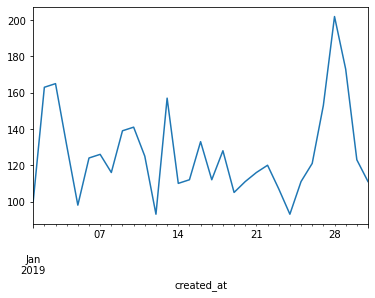

In [14]:
tweets.resample('1d', on='created_at').size().plot()

### Words

In [15]:
vocab = build_vocabulary(tweets, 'token')
vocab

token  frequency
0            the       5093
1             to       3372
2            and       2514
3              a       2375
4             of       2351
...          ...        ...
16581   millisle          1
16582    parking          1
16583  millionth          1
16584   parkland          1
16585          🧬          1

[16586 rows x 2 columns]

<AxesSubplot:ylabel='Frequency'>

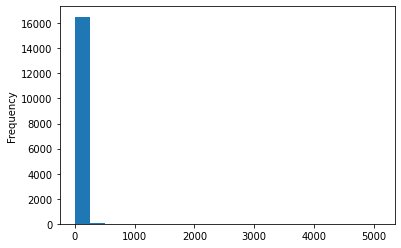

In [16]:
vocab['frequency'].plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

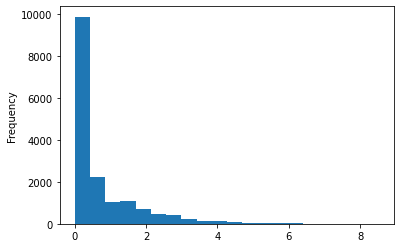

In [17]:
np.log(vocab['frequency']).plot(kind='hist', bins=20)

In [18]:
filtered_vocab = vocab[vocab['frequency'].between(5, vocab['frequency'].quantile(0.985))].reset_index(drop=True)
filtered_vocab

token  frequency
0                 year         60
1             benefits         60
2              english         60
3               remain         60
4                    1         60
...                ...        ...
2536           speaker          5
2537              jews          5
2538  @davesmi98608405          5
2539   @irisheurophile          5
2540            pissed          5

[2541 rows x 2 columns]

In [19]:
filtered_vocab.sort_values('frequency', ascending=False).head(25)

token  frequency
0           year         60
4              1         60
5         seeker         60
1       benefits         60
3         remain         60
2        english         60
6           look         59
7           ever         59
8          point         59
9        economy         59
10      refugees         59
11        future         59
12        voting         59
13         needs         58
14           end         58
18          used         57
21          anti         57
20  #immigration         57
19           i'm         57
16        coming         57
15         agree         57
17        having         57
22             😡         56
23       britain         56
24         party         56

### Geographical Context

In [20]:
tweets['place_name'].unique().shape

(839,)

<AxesSubplot:>

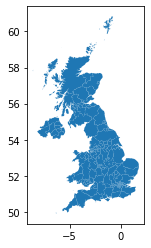

In [21]:
# https://www.geoboundaries.org/index.html#getdata
gdf = gpd.read_file('https://raw.githubusercontent.com/wmgeolab/geoBoundaries/793caebea9ccb4bb1c4f38e80684c1166daf288a/releaseData/gbOpen/GBR/ADM2/geoBoundaries-GBR-ADM2-all.zip')
gdf['geometry'] = gdf.simplify(0.0001)
gdf.plot()

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

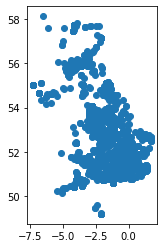

In [22]:
# somehow lat and lon are reversed in the original data.

tweets = to_point_geodataframe(tweets, 'lat', 'long', drop=True)
tweets.plot()

<AxesSubplot:>

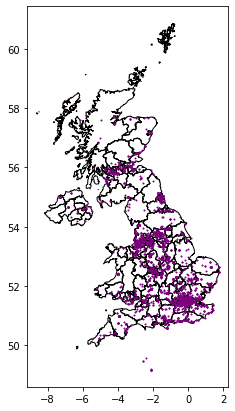

In [23]:
ax = gdf.plot(facecolor='none', edgecolor='black', figsize=(7, 7))
tweets.plot(ax=ax, color='purple', markersize=1)

In [24]:
len(gpd.sjoin(tweets, gdf, op='within'))

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


3901

In [25]:
tweets = gpd.sjoin(tweets, gdf, op='within')
print(len(tweets))
tweets.head()

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


3901


tweet_id                created_at           author_id  \
0    1080251664802689025 2019-01-01 23:57:21+00:00           246459126   
79   1080035317665677312 2019-01-01 09:37:40+00:00          1052521027   
176  1080521462199537664 2019-01-02 17:49:26+00:00  919890998959976450   
264  1080973461454049281 2019-01-03 23:45:31+00:00  704762496016654336   
309  1080895241291468801 2019-01-03 18:34:42+00:00           612544899   

             place_id place_name    full_place_name  exact_coords  \
0    544762ebf7fda780  Islington  Islington, London         False   
79   544762ebf7fda780  Islington  Islington, London         False   
176  544762ebf7fda780  Islington  Islington, London         False   
264  544762ebf7fda780  Islington  Islington, London         False   
309  544762ebf7fda780  Islington  Islington, London         False   

                                          bbox place_type country_code  ...  \
0    -0.1420579 51.5185518 -0.076305 51.575301       city           GB  ...   
79   -0.1420579 51.5185518 -0.076305 51.575301       city           GB  ...   
176  -0.1420579 51.5185518 -0.076305 51.575301       city           GB  ...   
264  -0.1420579 51.5185518 -0.076305 51.575301       city           GB  ...   
309  -0.1420579 51.5185518 -0.076305 51.575301       city           GB  ...   

    linked_url possibly_sensitive  \
0                           False   
79                          False   
176                         False   
264                         False   
309                         False   

                                                 token  \
0    [@arrondavid12, @anitabellows12, @swottyler, @...   
79   [@thattimwalker, @bbcnews, there, is, no, migr...   
176  [founded, an, award, winning, pro-bono, projec...   
264  [@wegesusanne, @theasylum5, @realdonaldtrump, ...   
309  [@bechhof, couldn’t, a, high, skilled, migrant...   

                      geometry  index_right  shapeName Level  \
0    POINT (-0.10918 51.54693)          110  Islington  ADM2   
79   POINT (-0.10918 51.54693)          110  Islington  ADM2   
176  POINT (-0.10918 51.54693)          110  Islington  ADM2   
264  POINT (-0.10918 51.54693)          110  Islington  ADM2   
309  POINT (-0.10918 51.54693)          110  Islington  ADM2   

                       shapeID shapeGroup  shapeType  
0    GBR-ADM2-9080712B23853987        GBR       ADM2  
79   GBR-ADM2-9080712B23853987        GBR       ADM2  
176  GBR-ADM2-9080712B23853987        GBR       ADM2  
264  GBR-ADM2-9080712B23853987        GBR       ADM2  
309  GBR-ADM2-9080712B23853987        GBR       ADM2  

[5 rows x 44 columns]

*Potential bug!* How do you know that all tweets are within your geography? If not, the index will have gaps. It would be better to reset it.

In [26]:
tweets = tweets.reset_index(drop=True)

In [27]:
location_counts = (
    tweets.groupby("shapeName")
    .size()
    .sort_values(ascending=False)
    .rename("n_tweets")
)

location_counts.head()

shapeName
Southwark               129
Westminster             108
Cambridgeshire           88
Lancashire               78
Kingston upon Thames     78
Name: n_tweets, dtype: int64

<AxesSubplot:>

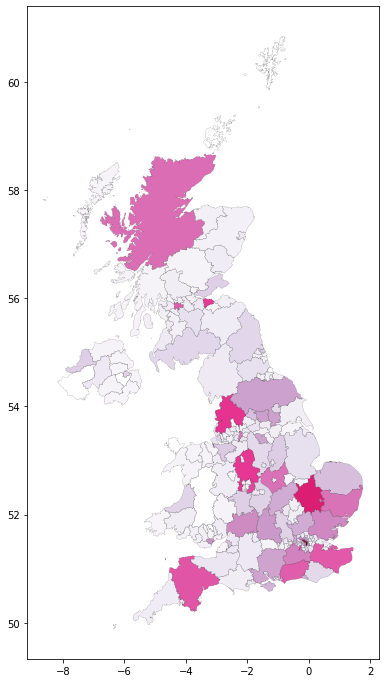

In [28]:
ax = gdf.join(location_counts, on='shapeName', how='inner').plot(column='n_tweets', cmap='PuRd', edgecolor='none', figsize=(12, 12))
gdf.plot(facecolor='none', edgecolor='black', linewidth=0.1, ax=ax)

## Narratives

### Main Representation: Document-Term Matrix

In [29]:
dtm = tokens_to_document_term_matrix(tweets, 'tweet_id', 'token', filtered_vocab['token'])
dtm

<3901x2541 sparse matrix of type '<class 'numpy.int64'>'
	with 33291 stored elements in Compressed Sparse Row format>

We observed that the most frequent words are not necessarily the most informative. We filtered out some of them, but that only diminishes the problem.

One way of improving the situation is to assign a weight to each word.

The most common weighting formula is TF-IDF.

In [30]:
tfidf = TfidfTransformer()

dtm_weighted = tfidf.fit_transform(dtm)
dtm_weighted

<3901x2541 sparse matrix of type '<class 'numpy.float64'>'
	with 33291 stored elements in Compressed Sparse Row format>

In [31]:
word_importances = sparse_matrix_to_long_dataframe(dtm_weighted, var_map=filtered_vocab['token'].to_dict())
word_importances

index           column     value
0         12             year  0.194392
1         92             year  0.276628
2         98             year  0.212427
3        136             year  0.234096
4        268             year  0.230491
...      ...              ...       ...
33286   2595  @irisheurophile  0.196370
33287    761           pissed  0.461081
33288   1424           pissed  0.400095
33289   3531           pissed  0.700363
33290   3842           pissed  0.316353

[33291 rows x 3 columns]

In [32]:
global_word_importance = (
    word_importances.groupby("column")["value"]
    .sum()
    .sort_values(ascending=False)
)
global_word_importance.head(25)


column
prioritise      21.690663
train           19.499190
prioritises     18.627493
seeker          18.216361
abroad          18.164697
#immigration    17.931048
polling         17.012169
needs           16.609495
voting          16.607222
trafficking     16.598315
worse           16.563463
english         16.317661
oh              16.315304
cc              16.185959
anti            16.083260
@lbc            15.999266
1               15.904892
end             15.811829
refugees        15.774962
let             15.756292
remain          15.737472
i'm             15.525567
agree           15.485241
year            15.241583
look            15.232203
Name: value, dtype: float64

In [33]:
place_tweet_idx = (
    tweets.groupby("shapeName")
    .apply(lambda x: x.index.values)
    #.loc[location_counts.index]
)

place_tweet_idx

shapeName
Aberdeen City              [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...
Aberdeenshire                                       [3123, 3124, 3125, 3126]
Angus                       [3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144]
Antrim and Newtownabbey                                               [3885]
Ards and North Down                                       [3695, 3696, 3697]
                                                 ...                        
Wokingham                               [3698, 3699, 3700, 3701, 3702, 3703]
Wolverhampton                     [1588, 1589, 1590, 1591, 1592, 1593, 1594]
Worcestershire             [3408, 3409, 3410, 3411, 3412, 3413, 3414, 341...
Wrexham                    [3810, 3811, 3812, 3813, 3814, 3815, 3816, 381...
York                       [2332, 2333, 2334, 2335, 2336, 2337, 2338, 233...
Length: 204, dtype: object

In [34]:
place_dtm = np.vstack(place_tweet_idx.map(lambda x: np.squeeze(np.array(dtm[x].sum(axis=0)))))
place_dtm.shape


(204, 2541)

In [35]:
place_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [36]:
place_words = pd.DataFrame(
    tfidf.transform(place_dtm).todense(),
    index=place_tweet_idx.index,
    columns=filtered_vocab["token"],
)

place_words

token                    year  benefits  english    remain    1    seeker  \
shapeName                                                                   
Aberdeen City             0.0  0.000000      0.0  0.000000  0.0  0.000000   
Aberdeenshire             0.0  0.000000      0.0  0.000000  0.0  0.000000   
Angus                     0.0  0.000000      0.0  0.000000  0.0  0.222339   
Antrim and Newtownabbey   0.0  0.000000      0.0  0.000000  0.0  0.000000   
Ards and North Down       0.0  0.000000      0.0  0.000000  0.0  0.000000   
...                       ...       ...      ...       ...  ...       ...   
Wokingham                 0.0  0.000000      0.0  0.000000  0.0  0.000000   
Wolverhampton             0.0  0.000000      0.0  0.000000  0.0  0.000000   
Worcestershire            0.0  0.151660      0.0  0.000000  0.0  0.000000   
Wrexham                   0.0  0.000000      0.0  0.000000  0.0  0.000000   
York                      0.0  0.056842      0.0  0.057032  0.0  0.000000   

token                        look  ever     point  economy  ...  size  jew  \
shapeName                                                   ...              
Aberdeen City            0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Aberdeenshire            0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Angus                    0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Antrim and Newtownabbey  0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Ards and North Down      0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
...                           ...   ...       ...      ...  ...   ...  ...   
Wokingham                0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Wolverhampton            0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Worcestershire           0.000000   0.0  0.000000      0.0  ...   0.0  0.0   
Wrexham                  0.076105   0.0  0.000000      0.0  ...   0.0  0.0   
York                     0.000000   0.0  0.057032      0.0  ...   0.0  0.0   

token                    currency  60s  sky  speaker  jews  @davesmi98608405  \
shapeName                                                                      
Aberdeen City                 0.0  0.0  0.0      0.0   0.0               0.0   
Aberdeenshire                 0.0  0.0  0.0      0.0   0.0               0.0   
Angus                         0.0  0.0  0.0      0.0   0.0               0.0   
Antrim and Newtownabbey       0.0  0.0  0.0      0.0   0.0               0.0   
Ards and North Down           0.0  0.0  0.0      0.0   0.0               0.0   
...                           ...  ...  ...      ...   ...               ...   
Wokingham                     0.0  0.0  0.0      0.0   0.0               0.0   
Wolverhampton                 0.0  0.0  0.0      0.0   0.0               0.0   
Worcestershire                0.0  0.0  0.0      0.0   0.0               0.0   
Wrexham                       0.0  0.0  0.0      0.0   0.0               0.0   
York                          0.0  0.0  0.0      0.0   0.0               0.0   

token                    @irisheurophile  pissed  
shapeName                                         
Aberdeen City                        0.0     0.0  
Aberdeenshire                        0.0     0.0  
Angus                                0.0     0.0  
Antrim and Newtownabbey              0.0     0.0  
Ards and North Down                  0.0     0.0  
...                                  ...     ...  
Wokingham                            0.0     0.0  
Wolverhampton                        0.0     0.0  
Worcestershire                       0.0     0.0  
Wrexham                              0.0     0.0  
York                                 0.0     0.0  

[204 rows x 2541 columns]

In [37]:
place_words.T.apply(lambda x: x.sort_values(ascending=False).head(10).index).T


0             1          2                3  \
shapeName                                                                       
Aberdeen City              assuming      scottish         cc          polling   
Aberdeenshire             christian        skills  exploring          leading   
Angus                          liar      scottish   controls           seeker   
Antrim and Newtownabbey  journalist        fellow    balance         interest   
Ards and North Down          driver         gonna    special             wont   
...                             ...           ...        ...              ...   
Wokingham                 @uklabour          part     banker           budget   
Wolverhampton                 heart         means        cta          teacher   
Worcestershire              managed  transitional    natural       protection   
Wrexham                           😡      believed       curb           #bbcqt   
York                          we’re        saying      state  @terrychristian   

                                4           5         6               7  \
shapeName                                                                 
Aberdeen City              you’re      abroad   options         mistake   
Aberdeenshire             rubbish        joke  absolute        nonsense   
Angus                       ready      macron         k            indy   
Antrim and Newtownabbey      nice     allowed     seems      manchester   
Ards and North Down         stuff         per      gets            ones   
...                           ...         ...       ...             ...   
Wokingham                   steel  abstention  shambles            mark   
Wolverhampton                uk's      budget   picture        freedoms   
Worcestershire              build           😂  benefits  @alyssa_milano   
Wrexham                  disaster   austerity      knew           blame   
York                        group      agreed      rise           isn't   

                                    8          9  
shapeName                                         
Aberdeen City              repeatedly  volunteer  
Aberdeenshire                       6    running  
Angus                         🏴󠁧󠁢󠁳󠁣󠁴󠁿       mugs  
Antrim and Newtownabbey       special     talent  
Ards and North Down               red    society  
...                               ...        ...  
Wokingham                 #stopbrexit     nearly  
Wolverhampton                speakers   payments  
Worcestershire                caravan      helps  
Wrexham                  uncontrolled       fool  
York                             fear    leaving  

[204 rows x 10 columns]

## Topic Model: Non-Negative Matrix Factorization

[NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) is based on the decomposition of the document-term matrix into the multiplication of two matrices with rank $k$ (the number of topics): one with the association between documents and topics, and one with topics and terms from the vocabulary. The model is fitted by finding a local optimum to the minimization of matrix reconstruction error.

In [38]:
nmf_model = NMF(n_components=20, random_state=42)
nmf_document_topic = nmf_model.fit_transform(dtm_weighted)

In [39]:
nmf_term_topic = nmf_model.components_
nmf_term_topic.shape

(20, 2541)

In [40]:
nmf_term_topic = pd.DataFrame(nmf_term_topic.T, index=filtered_vocab['token']).pipe(normalize_rows)
nmf_term_topic

0         1         2         3         4         5   \
token                                                                          
year              0.000000  0.003555  0.000000  0.304723  0.019487  0.004509   
benefits          0.000000  0.000000  0.000000  0.753860  0.000000  0.002401   
english           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
remain            0.234528  0.004854  0.143631  0.542244  0.009997  0.000000   
1                 0.000000  0.025808  0.000000  0.553212  0.028511  0.000000   
...                    ...       ...       ...       ...       ...       ...   
speaker           0.117600  0.000000  0.000000  0.276891  0.000000  0.000000   
jews              0.000000  0.000000  0.000000  0.856398  0.000000  0.000000   
@davesmi98608405  0.000000  0.000000  0.000000  0.859599  0.000000  0.000000   
@irisheurophile   0.000000  0.000000  0.000000  0.625912  0.000000  0.000000   
pissed            0.000000  0.000000  0.000000  0.770595  0.000000  0.000000   

                        6         7    8         9         10        11  \
token                                                                     
year              0.000000  0.001218  0.0  0.000000  0.000000  0.647181   
benefits          0.000000  0.000000  0.0  0.003130  0.069572  0.000000   
english           0.031820  0.000000  0.0  0.923491  0.000000  0.020883   
remain            0.010338  0.000000  0.0  0.000000  0.000000  0.000000   
1                 0.000000  0.093437  0.0  0.014939  0.000000  0.000978   
...                    ...       ...  ...       ...       ...       ...   
speaker           0.082727  0.133220  0.0  0.000000  0.000000  0.038472   
jews              0.123692  0.000000  0.0  0.000000  0.000424  0.000000   
@davesmi98608405  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
@irisheurophile   0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
pissed            0.000000  0.000000  0.0  0.000000  0.000000  0.000000   

                        12        13        14        15        16        17  \
token                                                                          
year              0.019327  0.000000  0.000000  0.000000  0.000000  0.000000   
benefits          0.000000  0.000000  0.017011  0.064144  0.032106  0.000000   
english           0.000000  0.000071  0.000000  0.000000  0.000000  0.005429   
remain            0.000000  0.000000  0.000000  0.048198  0.006210  0.000000   
1                 0.163589  0.067471  0.049861  0.000000  0.000000  0.002195   
...                    ...       ...       ...       ...       ...       ...   
speaker           0.000000  0.022484  0.000000  0.039835  0.217809  0.000000   
jews              0.019487  0.000000  0.000000  0.000000  0.000000  0.000000   
@davesmi98608405  0.000000  0.000000  0.000000  0.000000  0.083323  0.057078   
@irisheurophile   0.000000  0.000000  0.000000  0.167893  0.000000  0.170399   
pissed            0.000000  0.118052  0.000000  0.000000  0.018481  0.000000   

                        18        19  
token                                 
year              0.000000  0.000000  
benefits          0.028655  0.029122  
english           0.009193  0.009113  
remain            0.000000  0.000000  
1                 0.000000  0.000000  
...                    ...       ...  
speaker           0.000000  0.070962  
jews              0.000000  0.000000  
@davesmi98608405  0.000000  0.000000  
@irisheurophile   0.035796  0.000000  
pissed            0.092873  0.000000  

[2541 rows x 20 columns]

In [41]:
sns.clustermap(nmf_term_topic)

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [42]:
nmf_term_topic.apply(lambda x: x.sort_values(ascending=False).head(25).index).add_prefix('topic_')

topic_0      topic_1          topic_2           topic_3     topic_4  \
0        yougov     staffing          trained              cont  priorities   
1            cc        train       prioritise           reverse    petition   
2       polling  prioritises             uk's        floodgates         add   
3        abroad    amendment           design              crap        name   
4   prioritised       mainly         released              fall      signed   
5          docs       driver             docs             chart        i've   
6      released         2015           listen       @paperghost     compact   
7       whether        cover          whether           @tfoale     calling   
8        listen    @juliahb1            allow             chose        goes   
9        remain        lorry          weren’t     @velvickchris        pact   
10       voters         date           donate              wing      global   
11         uk's        keeps           remain          straight    becoming   
12       design            x                r            wasted   statement   
13   travelling            😊  @nickferrarilbc      economically  @on_europe   
14            r      landing       particular           benefit     provide   
15            g  @ofocbrexit           voters          thoughts          un   
16        sight      regions          parties       demographic        size   
17      #labour   supporters              act             firms   committee   
18      speaker      attract            sajid            expect       sajid   
19        guide        hours         homeless            jeremy   knowledge   
20         hall      imagine            javid       @tolethorpe  @biddleian   
21   democratic          led              red        @jetjag100         mrs   
22       gained      drivers         speaking  @nickstevenson63       write   
23        spend     domestic            areas  @blueunicornmoon   forgotten   
24    treatment     enormous             else     @hamster_hami       agree   

           topic_5       topic_6          topic_7           topic_8  \
0           commit  independence            malta            debate   
1         provided            fm       compelling              #nhs   
2          funding       backing             trio          monday’s   
3        shortages        broken          perform             plans   
4            worse     confident    unaccompanied  #immigrationbill   
5            train          indy             miss           #police   
6      prioritises     #indyref2          stories        #austerity   
7           ticket          male          company          speaking   
8     universities      scottish              feb      government’s   
9    @cornwall8646        racism        important      #immigration   
10  @elizabethf100           60s            funny        everything   
11       @meyer_dj           snp            legal            govt’s   
12         winning        future          written         #grenfell   
13  @david_cameron         ready           across         #windrush   
14          police        voting        developed           doesn’t   
15          hating      european             ever         hospitals   
16        currency       🏴󠁧󠁢󠁳󠁣󠁴󠁿           safety              area   
17            baby       forever          seeking             homes   
18       shouldn't      breaking          theatre             vital   
19        promoted        father               21           worried   
20       transport       fascism  @spazjukreattiv             voice   
21       economies  conservative           forced            asking   
22      abstention        female          albania                mp   
23        deported         toxic          eritrea            impact   
24      manchester       @thesnp      afghanistan         interview   

        topic_9    topic_10             topic_11        topic_12  \
0     crossings      waters           

In [43]:
nmf_place_topic = nmf_model.transform(tfidf.transform(place_dtm))
nmf_place_topic = pd.DataFrame(nmf_place_topic, index=place_tweet_idx.index).add_prefix('topic_').pipe(normalize_rows)
nmf_place_topic

topic_0   topic_1   topic_2   topic_3   topic_4  \
shapeName                                                                   
Aberdeen City            0.314711  0.000000  0.048155  0.098983  0.000000   
Aberdeenshire            0.000000  0.000583  0.000000  0.302610  0.000000   
Angus                    0.000000  0.000000  0.000000  0.019691  0.000000   
Antrim and Newtownabbey  0.000000  0.000000  0.000000  1.000000  0.000000   
Ards and North Down      0.000000  0.000000  0.000000  0.487462  0.000000   
...                           ...       ...       ...       ...       ...   
Wokingham                0.000000  0.000028  0.000000  0.553633  0.023956   
Wolverhampton            0.000028  0.000000  0.006358  0.201956  0.003921   
Worcestershire           0.067005  0.000000  0.096643  0.135072  0.000000   
Wrexham                  0.000000  0.000000  0.000000  0.636129  0.019352   
York                     0.000000  0.035720  0.000000  0.437731  0.338695   

                          topic_5   topic_6   topic_7   topic_8   topic_9  \
shapeName                                                                   
Aberdeen City            0.000000  0.104116  0.000000  0.000000  0.007523   
Aberdeenshire            0.000000  0.000000  0.000000  0.000000  0.449713   
Angus                    0.002095  0.605483  0.000000  0.000000  0.000000   
Antrim and Newtownabbey  0.000000  0.000000  0.000000  0.000000  0.000000   
Ards and North Down      0.000000  0.000000  0.000000  0.452032  0.000000   
...                           ...       ...       ...       ...       ...   
Wokingham                0.000000  0.026877  0.000000  0.000000  0.000000   
Wolverhampton            0.000000  0.072122  0.000000  0.000000  0.171101   
Worcestershire           0.001582  0.000000  0.000000  0.000000  0.009482   
Wrexham                  0.000000  0.000000  0.000000  0.052869  0.148317   
York                     0.055148  0.000000  0.019368  0.000545  0.007417   

                         topic_10  topic_11  topic_12  topic_13  topic_14  \
shapeName                                                                   
Aberdeen City            0.040453  0.000000  0.019958  0.003675  0.066633   
Aberdeenshire            0.017400  0.000000  0.037646  0.043871  0.004530   
Angus                    0.002065  0.000000  0.309091  0.000822  0.000000   
Antrim and Newtownabbey  0.000000  0.000000  0.000000  0.000000  0.000000   
Ards and North Down      0.000000  0.000000  0.015624  0.000000  0.001898   
...                           ...       ...       ...       ...       ...   
Wokingham                0.083284  0.000000  0.000000  0.118904  0.000000   
Wolverhampton            0.380238  0.012039  0.000280  0.004677  0.071147   
Worcestershire           0.031362  0.006557  0.000000  0.074343  0.000000   
Wrexham                  0.000000  0.020960  0.000000  0.122373  0.000000   
York                     0.000000  0.011685  0.002923  0.012458  0.000000   

                         topic_15  topic_16  topic_17  topic_18  topic_19  
shapeName                                                                  
Aberdeen City            0.012482  0.000000  0.000000  0.014202  0.269110  
Aberdeenshire            0.009789  0.133858  0.000000  0.000000  0.000000  
Angus                    0.000000  0.000000  0.060753  0.000000  0.000000  
Antrim and Newtownabbey  0.000000  0.000000  0.000000  0.000000  0.000000  
Ards and North Down      0.000000  0.014816  0.000000  0.000000  0.028168  
...                           ...       ...       ...       ...       ...  
Wokingham                0.000000  0.000000  0.072171  0.044761  0.076386  
Wolverhampton            0.016517  0.049493  0.010122  0.000000  0.000000  
Worcestershire           0.322778  0.057005  0.015360  0.179099  0.003711  
Wrexham                  0.000000  0.000000  0.000000  0.000000  0.000000  
York                     0.000000  0.078311  0.000000  0.000000  0.000000  

[204 rows x 20 columns]

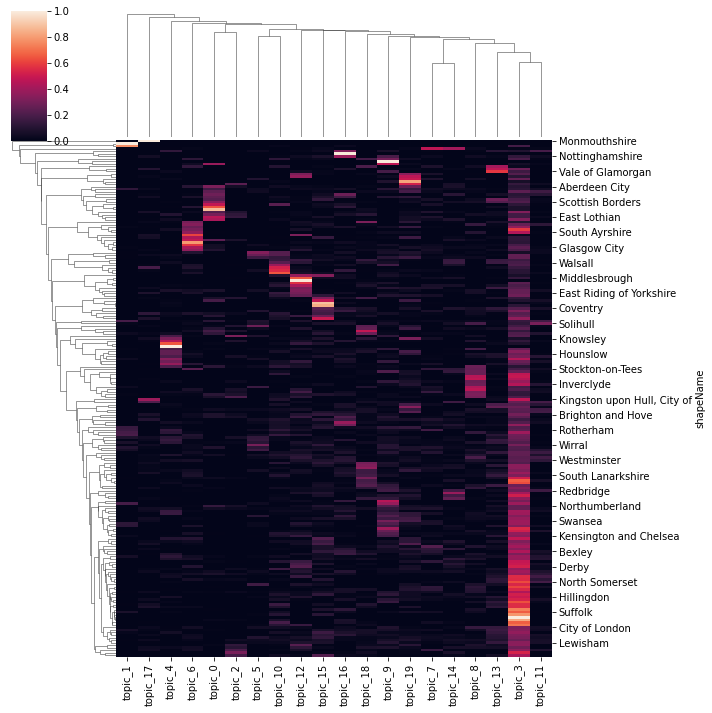

In [44]:
sns.clustermap(nmf_place_topic, metric='cosine')

In [45]:
nmf_topic_labels = nmf_term_topic.apply(lambda x: '\n'.join(x.sort_values(ascending=False).head(15).index))
nmf_topic_labels

0     yougov\ncc\npolling\nabroad\nprioritised\ndocs...
1     staffing\ntrain\nprioritises\namendment\nmainl...
2     trained\nprioritise\nuk's\ndesign\nreleased\nd...
3     cont\nreverse\nfloodgates\ncrap\nfall\nchart\n...
4     priorities\npetition\nadd\nname\nsigned\ni've\...
5     commit\nprovided\nfunding\nshortages\nworse\nt...
6     independence\nfm\nbacking\nbroken\nconfident\n...
7     malta\ncompelling\ntrio\nperform\nunaccompanie...
8     debate\n#nhs\nmonday’s\nplans\n#immigrationbil...
9     crossings\nbbc\nheld\nnews\nroyal\ntwo\nenglis...
10    waters\necj\nbackstops\ncustoms\nregain\nfishe...
11    #migration\n#immigrationmatters\n#britain\n#mi...
12    seeker\nattacks\nk\nwins\nwoman\nrahaf\nwon\nw...
13    trafficking\nslavery\n@whitehouse\nmodern\ndru...
14    heroes\nactors\nstars\nvalletta\nseparated\nce...
15    search\ncrimes\ncompassion\nfaced\nhate\ngreat...
16    firewall\n#caredontshare\n@libertyhq\nessentia...
17    #lawson\n#chandler\n#francois\n#kuenssberg

In [46]:
fig, axes = small_multiples_from_geodataframe(gdf, n_variables=len(nmf_place_topic.columns), height=7, col_wrap=5)

place_topic = nmf_place_topic
topic_labels = nmf_topic_labels

joint_gdf = gdf.join(place_topic, on='shapeName')

for ax, col, labels in zip(axes, place_topic.columns, topic_labels.values):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(ax, joint_gdf[joint_gdf[col] >= 0.05], col, edgecolor='black', linewidth=0.5, k=5, edgebinning="fisher_jenks", palette='RdPu',
        cbar_args=dict(
            label=f"{col}",
            height="25%",
            width="3%",
            orientation="vertical",
            location="lower left",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),)
    ax.set_title(col)

    ax.annotate(labels, (0.99, 0.99), xycoords='axes fraction', ha='right', va='top', fontsize='medium')


fig.tight_layout()


/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) 

### Latent Dirichlet Allocation (LDA)

[LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is based on a generative model based on how documents are structured: a document has topics, and topics has words, thus, a document is created by adding words to it from the topics that the document is about. It assumes that words and topics follow a Dirichlet distribution (hence the name). The model is fitted by finding the distribution parameters using Gibbs sampling or similar methods.

In [47]:
lda_model = LatentDirichletAllocation(n_components=20, random_state=42)
lda_document_topic = lda_model.fit_transform(dtm)
lda_term_topic = pd.DataFrame(lda_model.components_.T, index=filtered_vocab['token'])
lda_term_topic.apply(lambda x: x.sort_values(ascending=False).head(25).index)

0             1                 2            3            4   \
0            hate         isn't               war       status            –   
1               —          read           theresa      trained   prioritise   
2         customs       forward                 🙄   prioritise       abroad   
3          market       looking   @davidmetroland        maybe          let   
4            high  uncontrolled              iraq  trafficking         docs   
5           union           due         abstained     question      polling   
6          single          part  @gentlemangeorge       reason    reporting   
7   @jeremycorbyn          love     @charlie_uk45          key       school   
8        controls        answer           @twvasi       number          ask   
9         farming         point     @eddystone506        seems           cc   
10       welcomed         thank             needs        major       remain   
11      fisheries    prosperity  @awayfromthekeys         open      million   
12           ever           put         @kreppant      talking         able   
13       refugees          away  @billybigboleaux          ago         tell   
14          blood          team         @dw2essex         i’ve       having   
15            ecj         woman        @macid3000         look       what’s   
16       american        rather   @mattgeesymonds       issues          red   
17           best      euroland           @tsprog       modern      whether   
18           word     declining       @vikingavfc          net      friends   
19        britain          left   @brunothebridge     research     released   
20     protection     questions    @bruce83692351          try    something   
21         waters        morgan  @wittgenstein016         dear       access   
22         crimes           tim     @miguelsapimp          pro    essential   
23          cabal   @femi_sorry         @sunick51   referendum  enforcement   
24     compassion        things          refugees           oh       yougov   

            5             6             7                8             9   \
0        white        future          hard          housing             😡   
1       little        racism          keep             @lbc          anti   
2          bit        voting       believe         existing       ireland   
3       you’re         union           fom         stopping   trafficking   
4          net  independence     something          talking        issues   
5      economy      scottish         least          fucking          used   
6     remember         train  #immigration             used          real   
7         kind         young      positive           you’re          open   
8         post      staffing          long            means            oh   
9         says   prioritises          jobs       compromise     detention   
10      remain     confident        voters             jobs         stand   
11  @mrjamesob          male         agree          welfare       centres   
12        hour        broken           tax          between            ha   
13       value      european         story            using        middle   
14      aren’t       backing   sovereignty  @matthewstadlen     excellent   
15        @lbc         while       massive               gt  #immigration   
16      family          lost          hope      interesting          he's   
17     doesn’t           snp      industry            allow         irish   
18     getting            fm       economy            visas         night   
19       again           man        saying           around       decades   
20           1           old         heart            union         lgbtq   
21         got    #migration      @iandunt            we're        travel   
22      voting        growth       outside               oh        german   
23        laws         happy          news            order           non   
24          10       someone       

In [48]:
lda_place_topic = lda_model.transform(place_dtm)
lda_place_topic = pd.DataFrame(lda_place_topic, index=place_tweet_idx.index).add_prefix('topic_')
lda_place_topic

topic_0   topic_1   topic_2   topic_3   topic_4  \
shapeName                                                                   
Aberdeen City            0.000556  0.000556  0.000556  0.000556  0.156149   
Aberdeenshire            0.192741  0.001563  0.001563  0.001563  0.001563   
Angus                    0.200520  0.001087  0.001087  0.172681  0.047666   
Antrim and Newtownabbey  0.006250  0.006250  0.006250  0.006250  0.006250   
Ards and North Down      0.003571  0.003571  0.003571  0.003571  0.003571   
...                           ...       ...       ...       ...       ...   
Wokingham                0.001111  0.116879  0.001111  0.088085  0.001111   
Wolverhampton            0.000926  0.000926  0.105306  0.000926  0.000926   
Worcestershire           0.120125  0.000265  0.000265  0.067548  0.129674   
Wrexham                  0.088413  0.060869  0.000595  0.000595  0.000595   
York                     0.043433  0.060632  0.000279  0.000279  0.068340   

                          topic_5   topic_6   topic_7   topic_8   topic_9  \
shapeName                                                                   
Aberdeen City            0.230888  0.057353  0.000556  0.000556  0.000556   
Aberdeenshire            0.001563  0.001563  0.065455  0.001563  0.001563   
Angus                    0.001087  0.377028  0.001087  0.001087  0.001087   
Antrim and Newtownabbey  0.006250  0.006250  0.006250  0.006250  0.006250   
Ards and North Down      0.003571  0.003571  0.416786  0.003571  0.003571   
...                           ...       ...       ...       ...       ...   
Wokingham                0.312654  0.001111  0.001111  0.097746  0.056472   
Wolverhampton            0.101887  0.051250  0.050079  0.147118  0.188246   
Worcestershire           0.000265  0.000265  0.000265  0.000265  0.057299   
Wrexham                  0.295880  0.000595  0.000595  0.128332  0.177361   
York                     0.158618  0.055592  0.000279  0.000279  0.000279   

                         topic_10  topic_11  topic_12  topic_13  topic_14  \
shapeName                                                                   
Aberdeen City            0.000556  0.000556  0.140215  0.000556  0.000556   
Aberdeenshire            0.063746  0.171855  0.001563  0.001563  0.001563   
Angus                    0.001087  0.001087  0.001087  0.120810  0.001087   
Antrim and Newtownabbey  0.006250  0.006250  0.006250  0.006250  0.006250   
Ards and North Down      0.003571  0.518928  0.003571  0.003571  0.003571   
...                           ...       ...       ...       ...       ...   
Wokingham                0.001111  0.001111  0.001111  0.062213  0.001111   
Wolverhampton            0.050819  0.000926  0.112701  0.028426  0.000926   
Worcestershire           0.058156  0.069382  0.152446  0.000265  0.097619   
Wrexham                  0.000595  0.100471  0.000595  0.000595  0.076213   
York                     0.105269  0.000279  0.000279  0.028312  0.148790   

                         topic_15  topic_16  topic_17  topic_18  topic_19  
shapeName                                                                  
Aberdeen City            0.000556  0.105158  0.157308  0.081904  0.064358  
Aberdeenshire            0.001563  0.001563  0.001563  0.482766  0.001563  
Angus                    0.001087  0.001087  0.066077  0.001087  0.001087  
Antrim and Newtownabbey  0.006250  0.006250  0.006250  0.006250  0.881250  
Ards and North Down      0.003571  0.003571  0.003571  0.003571  0.003571  
...                           ...       ...       ...       ...       ...  
Wokingham                0.001111  0.001111  0.212023  0.001111  0.040594  
Wolverhampton            0.000926  0.154910  0.000926  0.000926  0.000926  
Worcestershire           0.000265  0.163618  0.000265  0.000265  0.081489  
Wrexham                  0.000595  0.065318  0.000595  0.000595  0.000595  
York                     0.093541  0.000279  0.036766  0.000279  0.198193  

[204 rows x 20 columns]

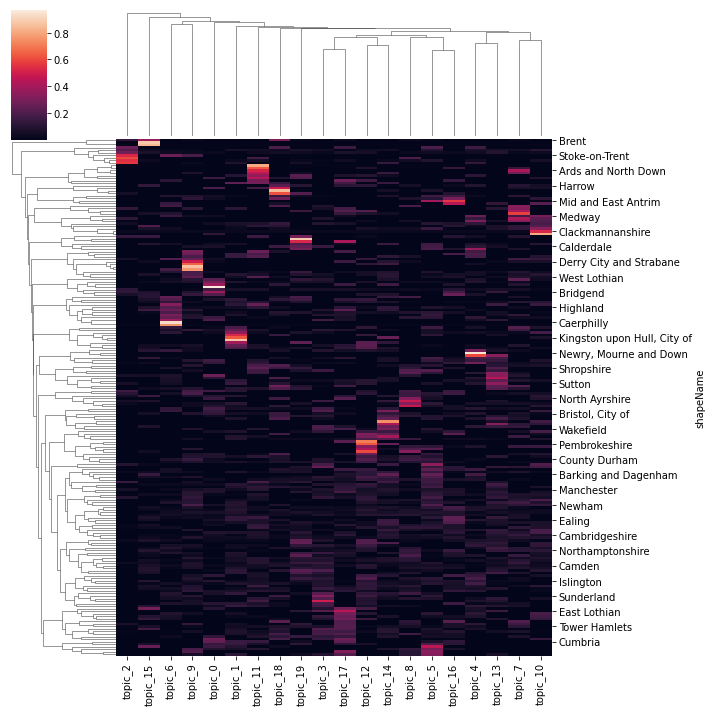

In [49]:
sns.clustermap(lda_place_topic, metric='cosine')

In [50]:
lda_topic_labels = lda_term_topic.apply(lambda x: '\n'.join(x.sort_values(ascending=False).head(15).index))
lda_topic_labels


0     hate\n—\ncustoms\nmarket\nhigh\nunion\nsingle\...
1     isn't\nread\nforward\nlooking\nuncontrolled\nd...
2     war\ntheresa\n🙄\n@davidmetroland\niraq\nabstai...
3     status\ntrained\nprioritise\nmaybe\ntraffickin...
4     –\nprioritise\nabroad\nlet\ndocs\npolling\nrep...
5     white\nlittle\nbit\nyou’re\nnet\neconomy\nreme...
6     future\nracism\nvoting\nunion\nindependence\ns...
7     hard\nkeep\nbelieve\nfom\nsomething\nleast\n#i...
8     housing\n@lbc\nexisting\nstopping\ntalking\nfu...
9     😡\nanti\nireland\ntrafficking\nissues\nused\nr...
10    speaking\n#immigration\n@davidlammy\nthat's\nh...
11    france\nnews\nenglish\nmakes\ntwo\nbbc\nheld\n...
12    worse\nhostile\nenvironment\nfunding\ntrain\ns...
13    un\npact\nsigned\nuse\nyear\nsense\ndoesn't\ng...
14    😂\nstate\ns\neveryone\nleast\nwatching\npoliti...
15    ever\nseeking\nimportant\nname\nmiss\nstories\...
16    both\njavid\nsecond\ntalk\ncan't\nsajid\nquite...
17    prioritised\neverything\nabroad\ncc\npolli

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python

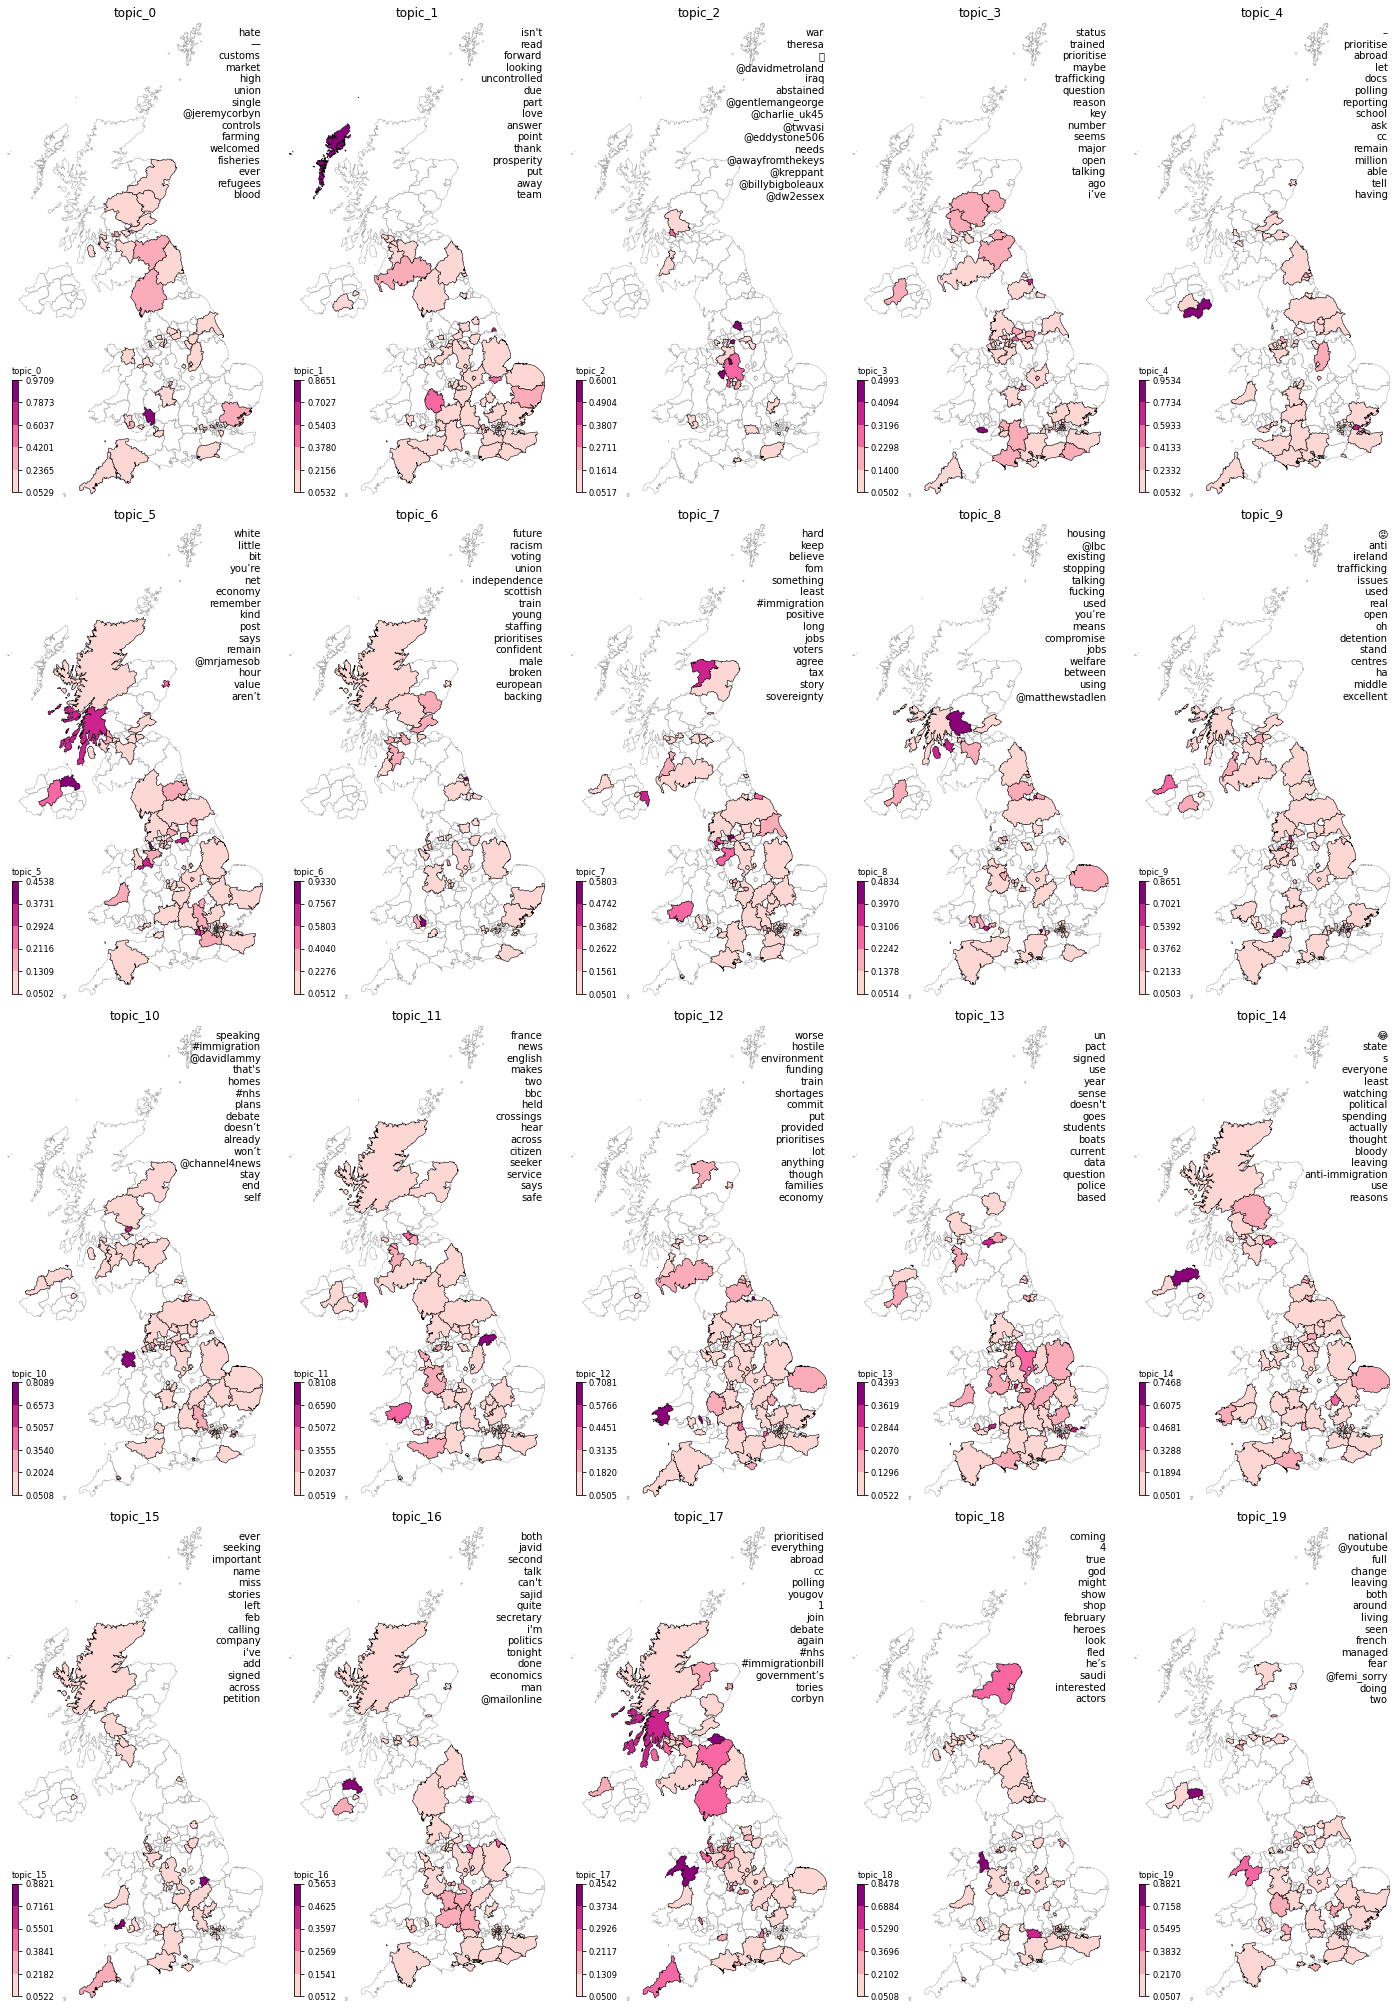

In [51]:
fig, axes = small_multiples_from_geodataframe(gdf, n_variables=len(lda_place_topic.columns), height=7, col_wrap=5)

place_topic = lda_place_topic
topic_labels = lda_topic_labels

joint_gdf = gdf.join(place_topic, on='shapeName')

for ax, col, labels in zip(axes, place_topic.columns, topic_labels.values):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(ax, joint_gdf[joint_gdf[col] >= 0.05], col, edgecolor='black', linewidth=0.5, k=5, edgebinning="fisher_jenks", palette='RdPu',
        cbar_args=dict(
            label=f"{col}",
            height="25%",
            width="3%",
            orientation="vertical",
            location="lower left",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),)
    ax.set_title(col)

    ax.annotate(labels, (0.99, 0.99), xycoords='axes fraction', ha='right', va='top', fontsize='medium')


fig.tight_layout()

Which one is better? We can't say. It will depend on your task :)

## Sentiment using Transformers

[Transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) are a deep learning architecture that processes sequences in such a way that the model is aware of the context of each term (where context is not only position, but also position of other words). They have been popularized due to their availability and the ability to fine-tune. Fine-tuning means that you can download a model and re-train it for your specific task, taking advantage of all previous structure already inferred by the model.

Fortunately, the Huggingface transformers library makes it very easy to download models and put them into operation.

In [52]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [53]:
# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
labels

['anger', 'joy', 'optimism', 'sadness']

In [54]:
def predict_emotion(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return pd.Series(scores, index=labels)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [55]:
predict_emotion("Good night 😊")

anger       0.012613
joy         0.906064
optimism    0.040697
sadness     0.040626
dtype: float32

In [56]:
sample_tweets= tweets[['text']].sample(5)
sample_tweets.join(sample_tweets['text'].apply(predict_emotion)).set_index('text')

anger       joy  \
text                                                                     
Thanks Ken for having us on your podcast! @Ross...  0.025415  0.482883   
@didierdelmer Seems there’s are far better solu...  0.875921  0.006323   
@pollymackenzie hearing you had a good laugh at...  0.020583  0.930649   
@NJamesWorld @Pumpwater1 @CatzPurrington 2/2..s...  0.159176  0.155310   
@Drury7Drury France is three times as big as UK...  0.333280  0.030358   

                                                    optimism   sadness  
text                                                                    
Thanks Ken for having us on your podcast! @Ross...  0.451380  0.040322  
@didierdelmer Seems there’s are far better solu...  0.031621  0.086135  
@pollymackenzie hearing you had a good laugh at...  0.033201  0.015567  
@NJamesWorld @Pumpwater1 @CatzPurrington 2/2..s...  0.473376  0.212138  
@Drury7Drury France is three times as big as UK...  0.092708  0.543653

In [57]:
tweet_emotions = tweets['text'].apply(predict_emotion)
tweet_emotions.describe()

anger          joy     optimism      sadness
count  3901.000000  3901.000000  3901.000000  3901.000000
mean      0.531051     0.115093     0.166744     0.187113
std       0.345093     0.233942     0.209182     0.209438
min       0.006597     0.003131     0.003887     0.004026
25%       0.182641     0.007746     0.029107     0.039846
50%       0.580912     0.013606     0.074796     0.100776
75%       0.875540     0.055183     0.208292     0.255635
max       0.983490     0.968590     0.946652     0.979029

In [58]:
place_sentiment = (
    tweets.join(tweet_emotions)
    .groupby("shapeName")[tweet_emotions.columns]
    .median()
    #.pipe(normalize_rows)
)
place_sentiment


anger       joy  optimism   sadness
shapeName                                                      
Aberdeen City            0.639323  0.020798  0.097068  0.157820
Aberdeenshire            0.940008  0.010588  0.016635  0.018621
Angus                    0.879649  0.013977  0.030591  0.063675
Antrim and Newtownabbey  0.873798  0.010756  0.056696  0.058750
Ards and North Down      0.056920  0.646021  0.050279  0.046097
...                           ...       ...       ...       ...
Wokingham                0.643327  0.020381  0.124104  0.153453
Wolverhampton            0.072756  0.034989  0.143669  0.100340
Worcestershire           0.484066  0.013133  0.113429  0.246278
Wrexham                  0.932314  0.005833  0.013633  0.051131
York                     0.623831  0.010748  0.084691  0.132651

[204 rows x 4 columns]

In [59]:
place_sentiment.sort_values('anger', ascending=False)

anger       joy  optimism   sadness
shapeName                                                                   
Kingston upon Hull, City of           0.953633  0.006946  0.018438  0.025536
East Lothian                          0.952432  0.007262  0.017537  0.025110
West Lothian                          0.947731  0.006009  0.018402  0.028291
Monmouthshire                         0.945125  0.024361  0.009363  0.021151
Aberdeenshire                         0.940008  0.010588  0.016635  0.018621
...                                        ...       ...       ...       ...
Brent                                 0.049209  0.596349  0.127396  0.037910
Pembrokeshire                         0.044069  0.055119  0.864124  0.036687
Armagh City, Banbridge and Craigavon  0.026895  0.546974  0.317433  0.030518
Causeway Coast and Glens              0.021645  0.818458  0.130963  0.028934
North Lincolnshire                    0.018127  0.839848  0.101051  0.040974

[204 rows x 4 columns]

/tmp/ipykernel_500/2387067704.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


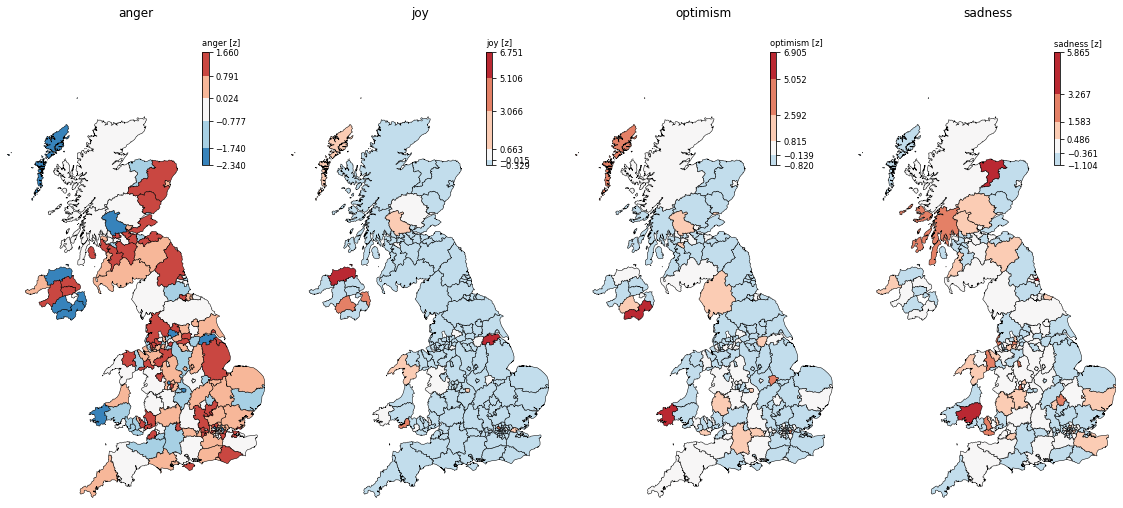

In [60]:
fig, axes = small_multiples_from_geodataframe(
    gdf, n_variables=len(labels), height=7, col_wrap=4, remove_axes=True
)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on="shapeName")

for ax, col in zip(axes, place_sentiment.columns):
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        cbar_args=dict(
            label=f"{col} [z]",
            height="25%",
            width="3%",
            orientation="vertical",
            location="upper right",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),
    )

    ax.set_title(col)


fig.tight_layout()


In [61]:
# https://woeplanet.org/id/23416974/
london_bbox = [-0.51035, 51.286839, 0.33403, 51.692322]
gdf_london = clip_area_geodataframe(gdf, london_bbox, buffer=0.01)
gdf_london.plot()


/home/egraells/resources/aves/src/aves/features/geo.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).pipe(lambda x: x[x.geometry.area > 0])


<AxesSubplot:>

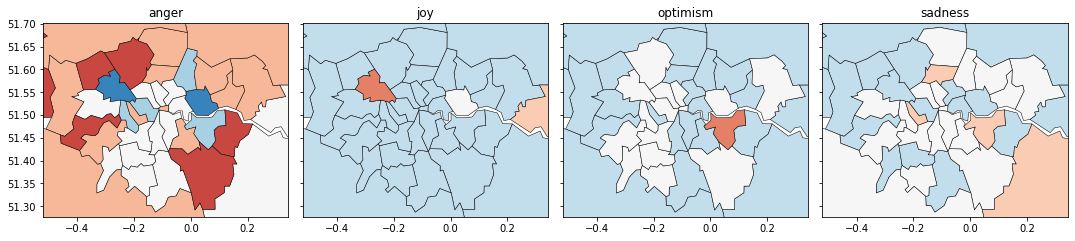

In [62]:
fig, axes = small_multiples_from_geodataframe(gdf_london, n_variables=len(labels), height=6, col_wrap=5, remove_axes=False)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on='shapeName')

for ax, col in zip(axes, place_sentiment.columns):
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        legend=None
    )
    #joint_gdf.plot(ax=ax, column=col, aspect=None, cmap='RdBu')
    #gdf.plot(facecolor='none', edgecolor='black', linewidth=0.1, ax=ax, aspect=None)
    ax.set_title(col)


fig.tight_layout()

In [63]:
aspect_ratio = (london_bbox[2] - london_bbox[0]) / (london_bbox[3] - london_bbox[1])
aspect_ratio

2.0824054276011736

/tmp/ipykernel_500/1904621091.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


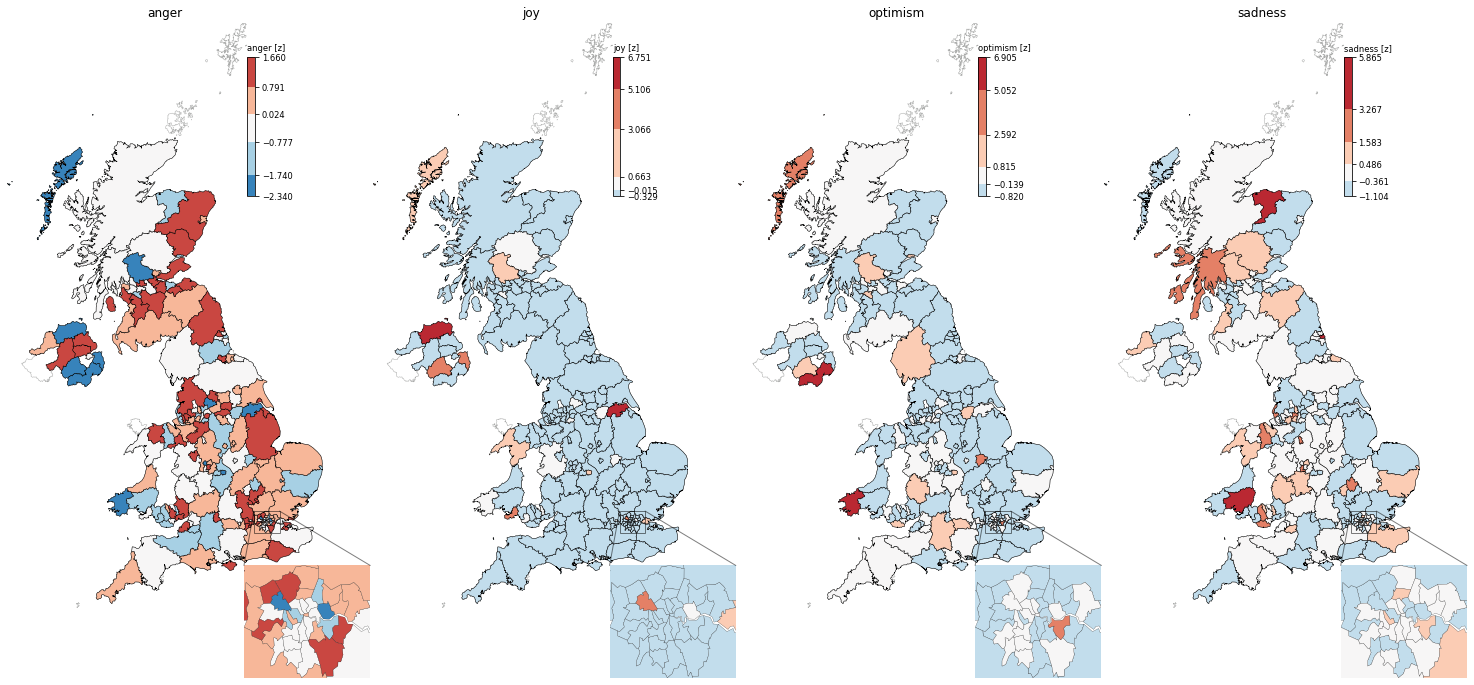

In [64]:
fig, axes = small_multiples_from_geodataframe(
    gdf, n_variables=4, height=9, col_wrap=4, remove_axes=True
)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on="shapeName")

for ax, col in zip(axes, place_sentiment.columns):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        cbar_args=dict(
            label=f"{col} [z]",
            height="25%",
            width="3%",
            orientation="vertical",
            location="upper right",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),
    )
    # joint_gdf.plot(ax=ax, column=col, aspect=None, cmap='RdBu')
    
    ax.set_title(col)

    axins = ax.inset_axes([0.75, -0.12, 0.4, 0.4 / aspect_ratio])
    axins.set_axis_off()
    #axins.imshow(Z2, extent=extent, origin="lower")
    # sub region of the original image
    #x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
    axins.set_xlim(london_bbox[0], london_bbox[2])
    axins.set_ylim(london_bbox[1], london_bbox[3])
    #axins.set_xticklabels([])
    #axins.set_yticklabels([])

    choropleth_map(
        axins,
        joint_gdf,
        col,
        k=5,
        linewidth=0.2,
        edgecolor="black",
        binning="fisher_jenks",
        legend=None
    )

    ax.indicate_inset_zoom(axins, edgecolor="black", zorder=50)


fig.tight_layout()

### Correlating Emotion and Narratives

We may want to characterize the topics underpinning the discussion. For instance, we cannot say with confidence that a topic characterized by a high association to a negative word is negative, because we don't know the context of the negative word. However, the sentiment characterization does that. 

Since we have estimated these measures for the same unit of analysis, one step toward characterizing topics is through correlation.

In [65]:
nmf_topic_x_emotion = (
    place_sentiment.join(nmf_place_topic)
    .fillna(0)
    .corr()
    .loc[nmf_place_topic.columns, place_sentiment.columns]
    .set_index(nmf_topic_labels.map(lambda x: x.replace("\n", ",")))
)

lda_topic_x_emotion = (
    place_sentiment.join(lda_place_topic)
    .fillna(0)
    .corr()
    .loc[lda_place_topic.columns, place_sentiment.columns]
    .set_index(lda_topic_labels.map(lambda x: x.replace("\n", ",")))
)


In [66]:
g = sns.clustermap(nmf_topic_x_emotion, center=0, figsize=(16, 9), annot=True, metric='cosine')
g.fig.tight_layout()

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:1203: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current font.
  self._figure.tight_layout(**tight_params)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:1203: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_500/2204994509.py:2: UserWarning: Glyph 129324 (\N{SERIOUS FACE WITH SYMBOLS COVERING MOUTH}) missing from current fo

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:1203: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_500/2498899210.py:2: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  g.fig.tight_layout()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


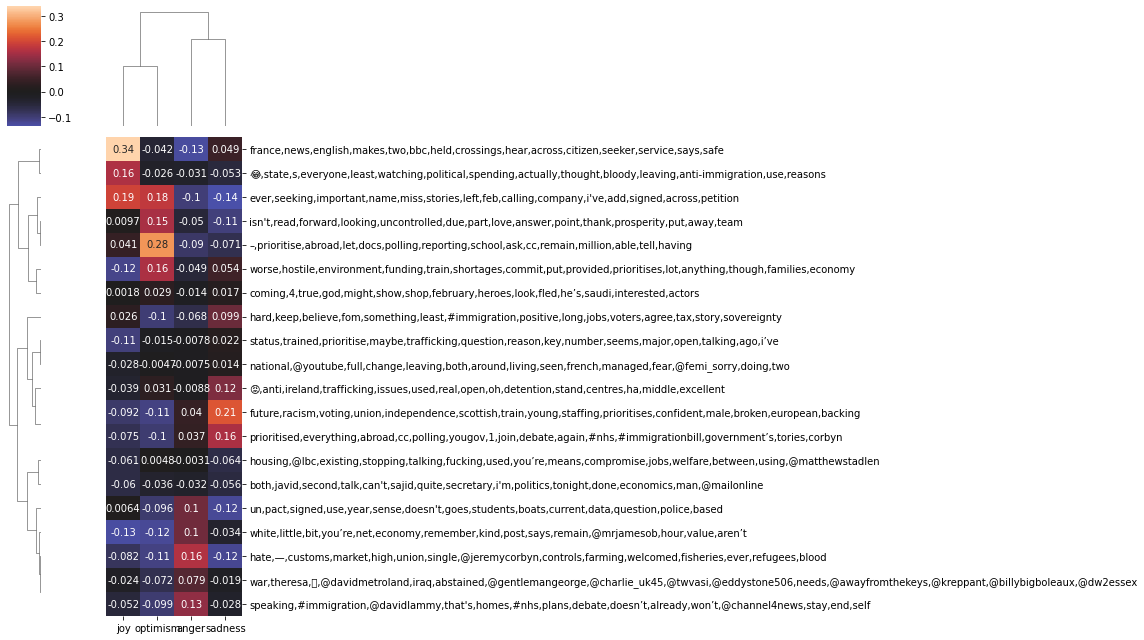

In [67]:
g = sns.clustermap(lda_topic_x_emotion, center=0, figsize=(16, 9), annot=True, metric='cosine')
g.fig.tight_layout()

Which one to pick? It seems that the results are not _that_ different. 

This is not the end of the study. We should do a careful qualitative analysis that can be supported by these numbers.


## Remaining Questions

### How to select a topic model?

My advice would be to test if simpler models give you reasonable results. If so, before moving to a more complex model, see if you can improve your data or your pre-processing. I like NMF for its simplicity and speed. And results are usually good enough. As with LDA, you can find evidence regarding its usefulness, thus, it is not a choice hard to justify.

Note that there are multiple versions of NMF and LDA. The [gensim](https://radimrehurek.com/gensim/) library is a good starting point as it has many implementations of those variants, as well as of other models.

### How to select the number of topics?

Do not focus only on quantitative measurements. Think about your assumptions of the data. Keep in mind typical evaluations (such as selecting a model based on Log-Likelihood or similar), but remember that those metrics are not necessarily related to your needs or assumptions about the data and the phenomena under study.

For instance, NMF tries to reconstruct the original matrix. As such, the "goodness of fit" is measured through matrix reconstruction error. You will notice that, as you increase the rank of the latent matrices, the fit improves always. 

Note that topics are _latent_, sometimes they do not have a human interpretation. A way to surpass this and have more interpretable topics is to use semi-supervised models. One of them is [Corex Topic Model](https://github.com/gregversteeg/corex_topic). where you can anchor words to topics as a way to guide the inference.

Always visualize what you do :) It will help you to pinpoint potential insights and also potential errors.

### Which transformer model to use?

I would say that every week there is a new model! The field is growing in a quite spectacular way, what I suggest is to find model authors that you trust and that have evaluated the new models in datasets similar to yours. For instance, here we used [tweeteval](https://github.com/cardiffnlp/tweeteval), which is trained and fine-tuned with tweets.

## Thanks!